In [1]:
# import libraries
import os
import re
import warnings 
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from dateutil import relativedelta
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Ignore all warnings
warnings.filterwarnings('ignore')

# Fetch weekly data 
wk_data_ecom = pd.DataFrame()
wk_data_instore = pd.DataFrame()

path1 = "T:\eMerging Channels\Power BI\eMerging Aggregate Dashboard\Data\Costco\Weekly Data Instore and EComm"
entries = os.listdir(path1)

# Loop to load data
for file in entries:
    ext = file[-3:]
    if "IN-STORE" in file.upper():
        df1 = pd.read_csv(path1+"\\"+file, skiprows=2)
        wk_data_instore = pd.concat([wk_data_instore, df1], ignore_index=True)
    elif "ECOM" in file.upper():
        df2 = pd.read_csv(path1+"\\"+file, skiprows=2)
        wk_data_ecom = pd.concat([wk_data_ecom, df2], ignore_index=True)

path2 = r"C:\Users\Kumaresan.C\Desktop\Data"
df1 = pd.read_csv(path2 + "\\" + "Costco ECOM Sales.csv")
df2 = pd.read_csv(path2 + "\\" + "Costco IN-STORE Sales.csv")        

ecom_df = pd.concat([df1, wk_data_ecom], ignore_index=True)
instore_df = pd.concat([df2, wk_data_instore], ignore_index=True)

In [2]:
# functiion to get number from the text        
def get_num(x):
    num = re.findall(r'\d+', x)         
    num = [int(i) for i in num if len(i) == 9]
    if len(num) > 0:
        return num[0]
    else:
        return 1

# Get the itemnumber from the item name    
ecom_df['Item_Number'] = ecom_df['Item'].apply(lambda x: get_num(x))   
instore_df['Item_Number'] = instore_df['Item'].apply(lambda x: get_num(x))

# Add Sales type to the df
ecom_df['Sale_Type'] = 'Ecom'
instore_df['Sale_Type'] = 'InStore'

# Concatinate
cols = ['Item', 'Time', 'Gross Units', 'Gross Dollars', 'Item_Number', 'Sale_Type']
items_df = pd.concat([ecom_df[cols], instore_df[cols]], ignore_index=True)

# load product master data
path2 = r"C:\Users\Kumaresan.C\Desktop\Data"

costcosku = pd.read_excel(path2 + "\\" + "CostcoSKUtoItemNumber.xlsx")
prod_master = pd.read_excel(path2 + "\\" + "ProductMaster20220930.xlsx")

# load holiday calender
hday_df = pd.read_excel(r"C:\Users\Kumaresan.C\Downloads\HolidayCalendar.xlsx")

# Drop null values 
costcosku.dropna(inplace=True)

In [3]:
# convert join key into string to map more records
items_df['Item_Number'] = items_df['Item_Number'].apply(lambda x: str(x).strip())
costcosku['SKU'] = costcosku['SKU'].apply(lambda x: str(int(x)).strip())
prod_master['Item Number'] = prod_master['Item Number'].apply(lambda x: str(x).strip())

# Merge sales data with master data
item_merge = pd.merge(items_df, costcosku, how='inner', left_on='Item_Number', right_on='SKU')
item_merge['ItemNumber'] = item_merge['ItemNumber'].apply(lambda x: str(x).strip())

merge_prod_master_item = pd.merge(item_merge, prod_master, how='inner', left_on='ItemNumber', right_on='Item Number')

In [4]:
# Get the date from the text
def d_find(x):
    match = re.search(r'\d{2}-\d{2}-\d{4}', x)
    dt = datetime.strptime(match.group(), '%m-%d-%Y').date()
    return dt
    
merge_prod_master_item['Date'] = merge_prod_master_item.Time.apply(lambda x: d_find(x))
merge_prod_master_item['Date'] = pd.to_datetime(merge_prod_master_item['Date'])

# Correct the data type
merge_prod_master_item['Gross Units'] = merge_prod_master_item['Gross Units'].apply(lambda x: int(x.replace(',',"") if type(x) not in (int, float) else x))
merge_prod_master_item.index = range(len(merge_prod_master_item))

In [5]:
# Add year, month to the df
merge_prod_master_item['Year'] = merge_prod_master_item['Date'].dt.year
merge_prod_master_item['Month'] = merge_prod_master_item['Date'].dt.month

hday_df['Year'] = hday_df['Holiday Date'].dt.year
hday_df['Month'] = hday_df['Holiday Date'].dt.month

In [38]:
# Merge with Holidays
merge_fin = pd.merge(merge_prod_master_item, hday_df, left_on=['Year', 'Month'], right_on=['Year', 'Month'], how='left')
dummy = pd.get_dummies(merge_fin['Holiday Name'])
merge_fin = pd.concat([merge_fin, dummy], axis=1)

# Select required columns
columns = ['Date', 'Year', 'Month', 'Gross Units', 'Gross Dollars', 'SKU', 'Manufacturer', 'Item Name', 'Retail Brand', 'Item Number', 
           'Product Category', 'Collection', 'Size', 'Level', 'Sale_Type', 'in lieu of Juneteenth',
           'Black Friday', 'Christmas Day', 'Columbus Day', 'Independence Day', 'Juneteenth', 'Labor Day', 'Martin Luther King, Jr.', 
           'Memorial Day', "New Year's Day", "Presidents' Day", "Thanksgiving Day", 'Veterans Day']
merge_fin = merge_fin[columns]

In [40]:
# Selecting items which has sales in last 5 months
items = merge_fin['Item Number'].unique()

final_df = pd.DataFrame()
for item in items:
#     Select a perticular item
    temp_df = merge_fin[merge_fin['Item Number'] == item]
    w = temp_df['Date'].max()
    tp_df = temp_df[temp_df['Gross Units'] > 0]
    if len(tp_df) > 0:
        tp_df = tp_df.sort_values(by='Date', ascending=False)
        x = tp_df['Date'].head().tolist()[0]
        y = w-x
        z = y.days/30
        if z <= 5:
#           Adding age of SKU
            mini = temp_df['Date'].min()
            now = datetime.today()
            delta = relativedelta.relativedelta(now, mini)
            temp_df['Age'] = delta.years          
            final_df = pd.concat([final_df,temp_df], ignore_index=True)

In [42]:
# capping outliers
def cap(x, l, h):
    if x > h:
        y = h
    elif x < l:
        y = l
    else:
        y = x
    return y

# Removing outliers using IQR
fin_df = pd.DataFrame()
data_chk = pd.DataFrame(columns=['Item', 'Before_min', 'Before_max', 'After_min', 'After_max', 'lo_lmt', 'up_lmt'])
for sku in final_df['Item Number'].unique():
    temp_df = final_df[final_df['Item Number'] == sku]
#     Get the lower and upper limit
    Q1 = temp_df['Gross Units'].quantile(0.25)
    Q3 = temp_df['Gross Units'].quantile(0.75)
    IQR = (Q3 - Q1)
    low_lmt = Q1 - (IQR * 1.5)
    up_lmt = Q3 + (IQR * 1.5)
#     Removing outliers
    bmi, bmx = temp_df['Gross Units'].min(), temp_df['Gross Units'].max() 
    
    temp_df['Gross Units'] = temp_df['Gross Units'].apply(lambda x: cap(x, low_lmt, up_lmt))
    ami, amx = temp_df['Gross Units'].min(), temp_df['Gross Units'].max() 
    data_chk.loc[len(data_chk)] = [sku, bmi, bmx, ami, amx, low_lmt, up_lmt]   
    fin_df = pd.concat([fin_df, temp_df], ignore_index=True)

In [43]:
print(fin_df.shape)
final_df = fin_df.copy()

(331650, 29)


In [44]:
final_df.columns

Index(['Date', 'Year', 'Month', 'Gross Units', 'Gross Dollars', 'SKU',
       'Manufacturer', 'Item Name', 'Retail Brand', 'Item Number',
       'Product Category', 'Collection', 'Size', 'Level', 'Sale_Type',
       'in lieu of Juneteenth', 'Black Friday', 'Christmas Day',
       'Columbus Day', 'Independence Day', 'Juneteenth', 'Labor Day',
       'Martin Luther King, Jr.', 'Memorial Day', 'New Year's Day',
       'Presidents' Day', 'Thanksgiving Day', 'Veterans Day', 'Age'],
      dtype='object')

In [60]:
# 'Product Category',
# Group the data with following level
grup_cols = ['Year', 'Age', 'Month', 'Size', 'Sale_Type', 'Retail Brand', 'Collection', 
             'in lieu of Juneteenth', 'Black Friday', 'Christmas Day', 'Columbus Day', 'Independence Day', 'Juneteenth', 'Labor Day', 
             'Martin Luther King, Jr.', 'Memorial Day', "New Year's Day", "Presidents' Day", "Thanksgiving Day", 'Veterans Day']
grp_df = final_df.groupby(grup_cols)['Gross Units'].sum().reset_index()

# Adding previows month sales to the data
items = grp_df['Collection'].unique()
model_df = pd.DataFrame()
for item in items:
    temp_df = grp_df[grp_df['Collection'] == item]
#     Sort them in ascending order
    temp_df = temp_df.sort_values(by=['Year','Month'])
    temp_df['pre_month_sales1'] = temp_df['Gross Units'].shift(1)
    temp_df['pre_month_sales2'] = temp_df['pre_month_sales1'].shift(1)
    temp_df['pre_month_sales3'] = temp_df['pre_month_sales2'].shift(1
    model_df = pd.concat([model_df, temp_df], ignore_index=True)    

In [122]:
model_df[model_df['Gross Units']<0]

,Year,Age,Month,Size,Sale_Type,Retail Brand,Collection,in lieu of Juneteenth,Black Friday,Christmas Day,...,Memorial Day,New Year's Day,Presidents' Day,Thanksgiving Day,Veterans Day,Gross Units,pre_month_sales1,pre_month_sales2,pre_month_sales3,DV
0,2018,4,1,CA King,Ecom,Sealy,Sealy PosturePedic Plus Spring,0,0,0,...,0,1,0,0,0,-0.269854,NaN,NaN,NaN,0
1,2018,4,1,CA King,Ecom,Sealy,Sealy PosturePedic Plus Spring,0,0,0,...,0,0,0,0,0,-0.269854,0.0,NaN,NaN,0
2,2018,4,1,CA King,InStore,Sealy,Sealy PosturePedic Plus Spring,0,0,0,...,0,1,0,0,0,-0.269854,0.0,0.0,NaN,0
3,2018,4,1,CA King,InStore,Sealy,Sealy PosturePedic Plus Spring,0,0,0,...,0,0,0,0,0,-0.269854,0.0,0.0,0.0,0
4,2018,4,1,King,Ecom,Sealy,Sealy PosturePedic Plus Spring,0,0,0,...,0,1,0,0,0,-0.269854,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6359,2022,3,7,Standard,InStore,Stearns & Foster,STEARNS AND FOSTER CLUB,0,0,0,...,0,0,0,0,0,-0.269275,2.0,5.0,1.0,1
6360,2022,3,8,Standard,Ecom,Stearns & Foster,STEARNS AND FOSTER CLUB,0,0,0,...,0,0,0,0,0,-0.269854,1.0,2.0,5.0,0
6361,2022,3,8,Standard,InStore,Stearns & Foster,STEARNS AND FOSTER CLUB,0,0,0,...,0,0,0,0,0,-0.269275,0.0,1.0,2.0,1
6362,2022,3,9,Standard,InStore,Stearns & Foster,STEARNS AND FOSTER CLUB,0,0,0,...,0,0,0,0,0,-0.269275,1.0,0.0,1.0,1


In [65]:
# model_df[model_df['Gross Units']<0]
# DV for Logistic Regression
model_df['DV'] = model_df['Gross Units'].apply(lambda x: 0 if x < 1 else 1)

In [66]:
model_df['DV'].value_counts()

1    3706
0    2658
Name: DV, dtype: int64

<AxesSubplot:xlabel='Gross Units', ylabel='Collection'>

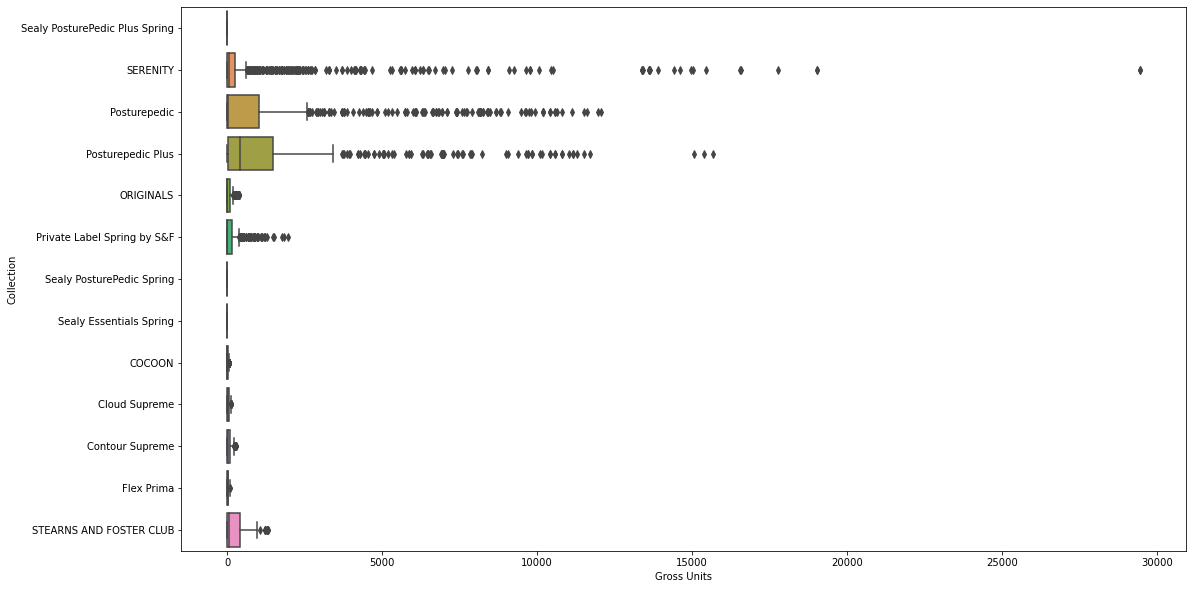

In [67]:
plt.figure(figsize=(18,10))
sns.boxplot(data=model_df, x="Gross Units", y="Collection")

In [52]:
model_df.columns

Index(['Year', 'Age', 'Month', 'Size', 'Sale_Type', 'Retail Brand',
       'Collection', 'in lieu of Juneteenth', 'Black Friday', 'Christmas Day',
       'Columbus Day', 'Independence Day', 'Juneteenth', 'Labor Day',
       'Martin Luther King, Jr.', 'Memorial Day', 'New Year's Day',
       'Presidents' Day', 'Thanksgiving Day', 'Veterans Day', 'Gross Units',
       'pre_month_sales1', 'pre_month_sales2', 'pre_month_sales3'],
      dtype='object')

## Logistic Model

In [73]:
# making dummies and adding to the dataframe
dummy1 = pd.get_dummies(merge_fin['Size'])
dummy3 = pd.get_dummies(merge_fin['Retail Brand'])

mod_df = pd.concat([model_df, dummy1, dummy3], axis=1)

In [74]:
# Encoding categorical labels
cols = ['Month', 'Size', 'Sale_Type', 'Collection', 'Retail Brand']
for col in cols:
    if mod_df[col].dtype in ['object', 'str']:
        le = preprocessing.LabelEncoder()
        mod_df[col] = le.fit_transform(mod_df[col]) 
        
# Sort values to split train and test
mod_df.sort_values(by=['Year', 'Month'], inplace=True, ignore_index=True)
mod_df.dropna(inplace=True)

In [75]:
mod_df.shape

(6325, 41)

In [78]:
# Train test split
train_df = mod_df.head(5000)
test_df = mod_df.tail(1325)

In [79]:
mod_df.columns

Index(['Year', 'Age', 'Month', 'Size', 'Sale_Type', 'Retail Brand',
       'Collection', 'in lieu of Juneteenth', 'Black Friday', 'Christmas Day',
       'Columbus Day', 'Independence Day', 'Juneteenth', 'Labor Day',
       'Martin Luther King, Jr.', 'Memorial Day', 'New Year's Day',
       'Presidents' Day', 'Thanksgiving Day', 'Veterans Day', 'Gross Units',
       'pre_month_sales1', 'pre_month_sales2', 'pre_month_sales3', 'DV',
       'CA King', 'CAL KING', 'Countour', 'Full', 'King', 'Queen',
       'SPLIT CAL KING', 'SPLIT KING', 'Standard',
       'Standard / Contour / Jumbo', 'Twin', 'Twin XL', 'Comfort Revolution',
       'Sealy', 'Stearns & Foster', 'Tempur-Pedic'],
      dtype='object')

In [81]:
# predictor variables
predictors = ['Age', 'Month', 'Sale_Type', 'Collection', 'in lieu of Juneteenth', 'Black Friday', 'Christmas Day',
       'Columbus Day', 'Independence Day', 'Juneteenth', 'Labor Day', 'Martin Luther King, Jr.', 'Memorial Day', "New Year's Day",
       "Presidents' Day", 'Thanksgiving Day', 'Veterans Day', 'pre_month_sales1', 'pre_month_sales2', 'pre_month_sales3',
       'CA King', 'CAL KING', 'Countour', 'Full', 'King', 'Queen', 'SPLIT CAL KING', 'SPLIT KING', 'Standard',
        'Standard / Contour / Jumbo', 'Twin', 'Twin XL', 'Comfort Revolution', 'Sealy', 'Stearns & Foster', 'Tempur-Pedic']

In [82]:
from sklearn.linear_model import LogisticRegression
train_x, train_y = train_df[predictors], train_df['DV']
test_x, test_y = test_df[predictors], test_df['DV']

In [83]:
clf = LogisticRegression(random_state=0).fit(train_x, train_y)

In [90]:
pred1 = clf.predict(train_x)
pred2 = clf.predict(test_x)

In [91]:
from sklearn.metrics import accuracy_score
acc1 = accuracy_score(train_y, pred1)
acc2 = accuracy_score(test_y, pred2)
print("Train Accuracy: ", acc1)
print("Test Accuracy: ", acc2)

Train Accuracy:  0.766
Train Accuracy:  0.7879245283018868


In [124]:
grp_df['Gross Units'].shape

(6364,)

## Regression Model

In [92]:
# Select Non Zero Sales Only
grp_df2 = grp_df[grp_df['Gross Units']>0]

# Adding previows month sales to the data
items = grp_df2['Collection'].unique()
model_df2 = pd.DataFrame()
for item in items:
    temp_df = grp_df2[grp_df2['Collection'] == item]
#     Sort them in ascending order
    temp_df = temp_df.sort_values(by=['Year','Month'])
    temp_df['pre_month_sales1'] = temp_df['Gross Units'].shift(1)
    temp_df['pre_month_sales2'] = temp_df['pre_month_sales1'].shift(1)
    temp_df['pre_month_sales3'] = temp_df['pre_month_sales2'].shift(1)
    model_df2 = pd.concat([model_df2, temp_df], ignore_index=True)    

## Normalizing Data

In [93]:
mu = model_df2['Gross Units'].mean()
std = model_df2['Gross Units'].std()

model_df2['Gross Units'] = model_df2['Gross Units'].apply(lambda x: (x-mu)/std)

# model_df['Gross Units'] = model_df['Gross Units'].apply(lambda x: np.sqrt(abs(x))*(x/abs(x)))

<AxesSubplot:>

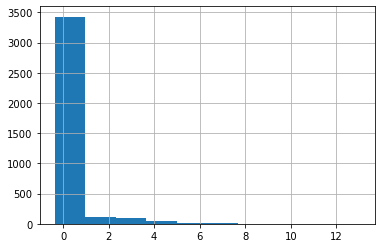

In [94]:
model_df2['Gross Units'].hist()

<AxesSubplot:xlabel='Gross Units'>

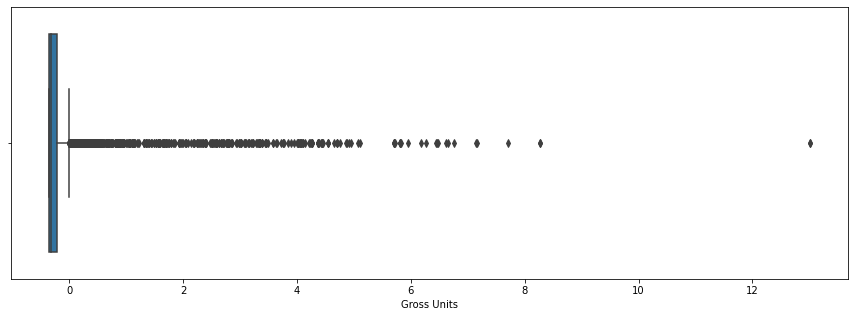

In [97]:
plt.figure(figsize=(15,5))
sns.boxplot(data=model_df2, x="Gross Units")

In [101]:
# making dummies and adding to the dataframe
dummy1 = pd.get_dummies(model_df2['Size'])
dummy3 = pd.get_dummies(model_df2['Retail Brand'])

mod_df = pd.concat([model_df2, dummy1, dummy3], axis=1)

# Encoding categorical labels
cols = ['Month', 'Size', 'Sale_Type', 'Collection', 'Retail Brand']
for col in cols:
    if mod_df[col].dtype in ['object', 'str']:
        le = preprocessing.LabelEncoder()
        mod_df[col] = le.fit_transform(mod_df[col]) 
        
# Sort values to split train and test
mod_df.sort_values(by=['Year', 'Month'], inplace=True, ignore_index=True)
mod_df.dropna(inplace=True)

In [106]:
mod_df.shape

(3677, 39)

In [107]:
train_df2.columns

Index(['Year', 'Age', 'Month', 'Size', 'Sale_Type', 'Retail Brand',
       'Collection', 'in lieu of Juneteenth', 'Black Friday', 'Christmas Day',
       'Columbus Day', 'Independence Day', 'Juneteenth', 'Labor Day',
       'Martin Luther King, Jr.', 'Memorial Day', 'New Year's Day',
       'Presidents' Day', 'Thanksgiving Day', 'Veterans Day', 'Gross Units',
       'pre_month_sales1', 'pre_month_sales2', 'pre_month_sales3', 'CA King',
       'CAL KING', 'Countour', 'Full', 'King', 'Queen', 'SPLIT CAL KING',
       'SPLIT KING', 'Standard', 'Twin', 'Twin XL', 'Comfort Revolution',
       'Sealy', 'Stearns & Foster', 'Tempur-Pedic'],
      dtype='object')

In [110]:
# Train test split
train_df2 = mod_df.head(3000)
test_df2 = mod_df.tail(677)

In [111]:
# predictor variables
predictors = ['Age', 'Month', 'Sale_Type', 'Collection', 'in lieu of Juneteenth', 'Black Friday', 'Christmas Day',
       'Columbus Day', 'Independence Day', 'Juneteenth', 'Labor Day',
       'Martin Luther King, Jr.', 'Memorial Day', "New Year's Day",
       "Presidents' Day", 'Thanksgiving Day', 'Veterans Day', 'pre_month_sales1', 'pre_month_sales2', 'pre_month_sales3', 'CA King',
       'CAL KING', 'Countour', 'Full', 'King', 'Queen', 'SPLIT CAL KING',
       'SPLIT KING', 'Standard', 'Twin', 'Twin XL', 'Comfort Revolution', 'Sealy', 'Stearns & Foster', 'Tempur-Pedic']

In [112]:
train_x, train_y = train_df2[predictors], train_df2['Gross Units']
test_x, test_y = train_df2[predictors], train_df2['Gross Units']

In [116]:
# Sk-learn Model
reg = LinearRegression().fit(train_x, train_y)

r2 = reg.score(train_x, train_y)
pred = reg.predict(test_x)
    
#     Metrics
rmse = np.sqrt(mean_squared_error(test_y, pred))

test_x['Actual'] = test_y
test_x['Predicted'] = np.round(pred, 2)

In [120]:
print("R-Square: ", r2)
print("RMSE: ", rmse)

R-Square:  0.3020792934375537
RMSE:  0.8655972366303168


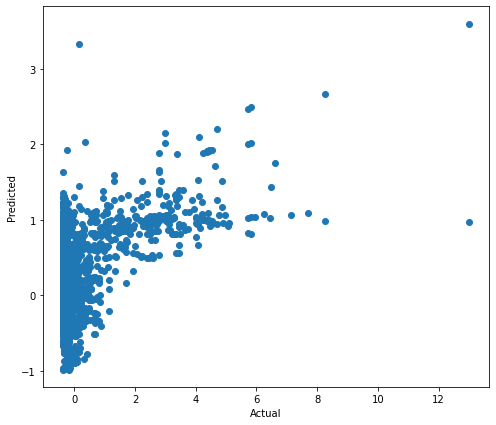

In [121]:
plt.figure(figsize=(8,7))
plt.scatter(test_x['Actual'], test_x['Predicted'])
plt.xlabel("Actual")
plt.ylabel('Predicted')
plt.show()

<AxesSubplot:xlabel='Gross Units', ylabel='Collection'>

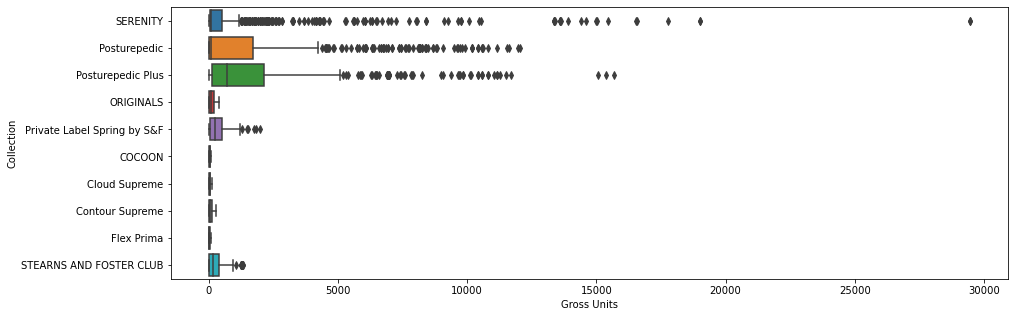

In [126]:

plt.figure(figsize=(15,5))
sns.boxplot(data=grp_df2, x="Gross Units", y="Collection")